<a href="https://colab.research.google.com/github/ftkbyond77/Advertisement_211/blob/main/Marketing_211_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hdbscan
import umap
from sklearn.manifold import TSNE

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# !nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
torch.cuda.empty_cache()

In [ ]:
config = {
    'batch_size': 64,
    'latent_dim': 256,
    'image_size': (128, 128),
    'epochs': 250,
    'lr': 3e-4,
    'beta': 80,  # Weight for KL divergence
}

In [ ]:
# data_transform = transforms.Compose([
#     transforms.Resize(config['image_size']),
#     transforms.RandomAdjustSharpness(0.2),
#     transforms.RandomRotation(15),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1]
# ])

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1]
])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# import gc
# del data
# try:
#     print(data)
# except NameError:
#     print("data has been deleted.")

data has been deleted.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# base_folder = '/content/drive/My Drive/Merged Files'
# torch.cuda.empty_cache()
# my_data = []

# for i in os.listdir(base_folder):
#     img_path = os.path.join(base_folder, i)

#     with Image.open(img_path) as image:
#         image = image.convert("RGB")
#         image_T = data_transform(image)
#         my_data.append(image_T.unsqueeze(0))

# data = torch.cat(my_data, dim=0).to(device)
# print(f"Dataset shape: {data.shape}")

Dataset shape: torch.Size([1115, 3, 128, 128])


In [ ]:
torch.save(data, "datasetX3_reverse.pt")

In [ ]:
torch.save(data, "datasetX3.pt")

In [ ]:
# data = torch.load('datasetX2.pt').to(device)

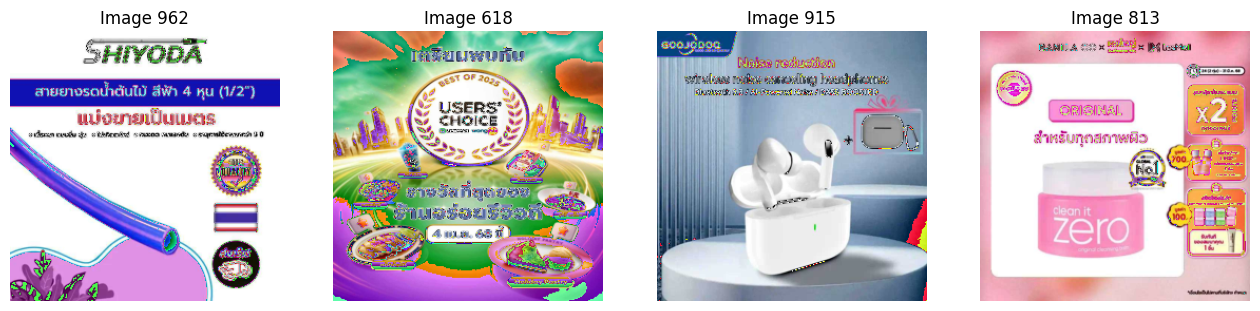

In [ ]:
import random

random_indices = random.sample(range(data.size(0)), 4)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, idx in enumerate(random_indices):
  image = transforms.ToPILImage()(data[idx].cpu())
  axes[i].imshow(image)
  axes[i].axis('off')
  axes[i].set_title(f'Image {idx + 1}')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [ ]:
# dataset = TensorDataset(data)
# dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Residual Connection
        return F.gelu(out)

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, mean=0.0, std=1.0):
        super(GaussianNoise, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        noise = torch.normal(self.mean, self.std, size=x.size()).to(x.device)
        return x + noise

In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=config['latent_dim'], beta=config['beta']):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta  # Regularization strength parameter for β-VAE

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)

        # Calculate size after convolutions
        self.fc_size = 1024 * 4 * 4

        # Latent representation
        self.fc_mu = nn.Linear(self.fc_size, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_size, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.fc_size)

        self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)

        self.bn7 = nn.BatchNorm2d(512)
        self.bn8 = nn.BatchNorm2d(256)
        self.bn9 = nn.BatchNorm2d(128)
        self.bn10 = nn.BatchNorm2d(64)
        self.bn11 = nn.BatchNorm2d(32)

        # Residual Block
        self.res_block1 = ResidualBlock(32)
        self.res_block2 = ResidualBlock(64)
        self.res_block3 = ResidualBlock(128)
        self.res_block4 = ResidualBlock(256)
        self.res_block5 = ResidualBlock(512)

        self.dec_res_block1 = ResidualBlock(512)
        self.dec_res_block2 = ResidualBlock(256)
        self.dec_res_block3 = ResidualBlock(128)
        self.dec_res_block4 = ResidualBlock(64)

        self.dropout = nn.Dropout(0.3)
        self.gaussian_noise = GaussianNoise(mean=0.0, std=0.1)

    def encode(self, x):
        # Encoder forward pass
        x = F.gelu(self.bn1(self.conv1(x)))
        x = self.res_block1(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.res_block2(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.res_block3(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn4(self.conv4(x)))
        x = self.res_block4(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn5(self.conv5(x)))
        x = self.res_block5(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn6(self.conv6(x)))
        x = x.view(-1, self.fc_size)
        x = self.dropout(x)
        # Return mean and log variance of the latent distribution
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        # Decoder forward pass
        x = F.gelu(self.fc_decoder(z))
        x = x.view(-1, 1024, 4, 4)

        x = F.gelu(self.bn7(self.deconv1(x)))
        x = self.dec_res_block1(x)
        x = F.gelu(self.bn8(self.deconv2(x)))
        x = self.dec_res_block2(x)
        x = F.gelu(self.bn9(self.deconv3(x)))
        x = self.dec_res_block3(x)
        x = F.gelu(self.bn10(self.deconv4(x)))
        x = self.dec_res_block4(x)
        x = F.gelu(self.bn11(self.deconv5(x)))
        x = torch.tanh(self.deconv6(x))  # Output in range [-1, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')

        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss with beta weighting for stronger regularization
        return recon_loss + self.beta * kl_loss, recon_loss, kl_loss


In [ ]:
# class BetaVAE(nn.Module):
#     def __init__(self, latent_dim=config['latent_dim'], beta=config['beta']):
#         super(BetaVAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.beta = beta  # Regularization strength parameter for β-VAE

#         # Encoder
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
#         self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
#         self.conv6 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)

#         # Calculate size after convolutions
#         self.fc_size = 1024 * 4 * 4

#         # Latent representation
#         self.fc_mu = nn.Linear(self.fc_size, latent_dim)
#         self.fc_logvar = nn.Linear(self.fc_size, latent_dim)

#         # Decoder
#         self.fc_decoder = nn.Linear(latent_dim, self.fc_size)

#         self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
#         self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
#         self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
#         self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
#         self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
#         self.deconv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

#         # Batch normalization for better training stability
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.bn5 = nn.BatchNorm2d(512)
#         self.bn6 = nn.BatchNorm2d(1024)

#         self.bn7 = nn.BatchNorm2d(512)
#         self.bn8 = nn.BatchNorm2d(256)
#         self.bn9 = nn.BatchNorm2d(128)
#         self.bn10 = nn.BatchNorm2d(64)
#         self.bn11 = nn.BatchNorm2d(32)

#     def encode(self, x):
#         # Encoder forward pass
#         x = F.gelu(self.bn1(self.conv1(x)))
#         x = F.gelu(self.bn2(self.conv2(x)))
#         x = F.gelu(self.bn3(self.conv3(x)))
#         x = F.gelu(self.bn4(self.conv4(x)))
#         x = F.gelu(self.bn5(self.conv5(x)))
#         x = F.gelu(self.bn6(self.conv6(x)))

#         x = x.view(-1, self.fc_size)

#         # Return mean and log variance of the latent distribution
#         mu = self.fc_mu(x)
#         logvar = self.fc_logvar(x)
#         return mu, logvar

#     def reparameterize(self, mu, logvar):
#         # Reparameterization trick
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         z = mu + eps * std
#         return z

#     def decode(self, z):
#         # Decoder forward pass
#         x = F.gelu(self.fc_decoder(z))
#         x = x.view(-1, 1024, 4, 4)

#         x = F.gelu(self.bn7(self.deconv1(x)))
#         x = F.gelu(self.bn8(self.deconv2(x)))
#         x = F.gelu(self.bn9(self.deconv3(x)))
#         x = F.gelu(self.bn10(self.deconv4(x)))
#         x = F.gelu(self.bn11(self.deconv5(x)))
#         x = torch.tanh(self.deconv6(x))  # Output in range [-1, 1]
#         return x

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         x_recon = self.decode(z)
#         return x_recon, mu, logvar

#     def loss_function(self, recon_x, x, mu, logvar):
#         # Reconstruction loss (MSE)
#         recon_loss = F.mse_loss(recon_x, x, reduction='sum')

#         # KL divergence loss
#         kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#         # Total loss with beta weighting for stronger regularization
#         return recon_loss + self.beta * kl_loss, recon_loss, kl_loss


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = BetaVAE(latent_dim=config['latent_dim'], beta=config['beta']).to(device)
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

In [ ]:
log_interval = 10
# Lists to store losses
train_losses = []
recon_losses = []
kl_losses = []
vali_loss = []

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# ส่วนที่ต้องเพิ่มก่อน loop การเทรน
best_val_loss = float('inf')
patience = 20  # จำนวน epochs ที่ยอมให้ validation loss ไม่ดีขึ้น
patience_counter = 0
early_stop = False

print("Starting training...")
for epoch in range(config['epochs']):
    model.train()
    train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    for batch_idx, (batch,) in enumerate(dataloader):
        batch = batch.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss, recon_loss, kl_loss = model.loss_function(recon_batch, batch, mu, logvar)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

    # Average loss for the epoch
    avg_loss = train_loss / len(dataloader.dataset)
    avg_recon_loss = epoch_recon_loss / len(dataloader.dataset)
    avg_kl_loss = epoch_kl_loss / len(dataloader.dataset)

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (val_batch,) in enumerate(val_dataloader):
            val_batch = val_batch.to(device)
            recon_batch, mu, logvar = model(val_batch)
            loss, _, _ = model.loss_function(recon_batch, val_batch, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    vali_loss.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    # Early Stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: New best model saved with val loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best val loss: {best_val_loss:.4f}")
            early_stop = True

    if (epoch + 1) % log_interval == 0:
        print(f"Epoch: {epoch+1}/{config['epochs']} | Train Loss: {avg_loss:.4f} | "
              f"Recon Loss: {avg_recon_loss:.4f} | KL Loss: {avg_kl_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Patience: {patience_counter}/{patience}")

    # ออกจาก loop หากเข้าเงื่อนไข early stopping
    if early_stop:
        break

# หลังจาก loop เทรนเสร็จสิ้น
if early_stop:
    model.load_state_dict(torch.load('best_model_reverse.pth'))
    print("Loaded best model from checkpoint.")

Starting training...
Epoch 1: New best model saved with val loss: 116751.3419
Epoch 2: New best model saved with val loss: 89695.5886
Epoch 5: New best model saved with val loss: 71778.7175
Epoch 6: New best model saved with val loss: 70107.8711
Epoch 8: New best model saved with val loss: 63578.5348
Epoch: 10/250 | Train Loss: 61623.4683 | Recon Loss: 57324.8946 | KL Loss: 21.4929 | Val Loss: 63941.6284 | Patience: 2/20
Epoch 11: New best model saved with val loss: 61904.7029
Epoch 14: New best model saved with val loss: 61368.6323
Epoch 15: New best model saved with val loss: 59565.1222
Epoch 19: New best model saved with val loss: 58976.8806
Epoch: 20/250 | Train Loss: 57597.4812 | Recon Loss: 53217.1707 | KL Loss: 21.9016 | Val Loss: 61696.6087 | Patience: 1/20
Epoch 22: New best model saved with val loss: 58112.9193
Epoch 23: New best model saved with val loss: 57736.0516
Epoch 26: New best model saved with val loss: 56784.8784
Epoch: 30/250 | Train Loss: 55501.7402 | Recon Loss: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def plot_loss_landscape(model, val_dataloader, device, steps=21, scale=1.0):
    model.eval()
    # ดึง vector พารามิเตอร์ปัจจุบัน
    theta = torch.nn.utils.parameters_to_vector(model.parameters()).detach()

    # สุ่มทิศทาง 2 ทิศทางใน weight space
    d1 = torch.randn_like(theta)
    d2 = torch.randn_like(theta)
    d1 = d1 / d1.norm()
    d2 = d2 / d2.norm()

    alpha = np.linspace(-scale, scale, steps)
    beta = np.linspace(-scale, scale, steps)
    loss_surface = np.zeros((steps, steps))

    for i, a in enumerate(alpha):
        for j, b in enumerate(beta):
            # new_theta = original + a*d1 + b*d2
            new_theta = theta + a * d1 + b * d2
            torch.nn.utils.vector_to_parameters(new_theta, model.parameters())

            # คำนวณ loss ของ validation
            val_loss = 0
            with torch.no_grad():
                for val_batch, in val_dataloader:
                    val_batch = val_batch.to(device)
                    recon_batch, mu, logvar = model(val_batch)
                    loss, _, _ = model.loss_function(recon_batch, val_batch, mu, logvar)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader.dataset)
            loss_surface[i, j] = avg_val_loss

    # วาดกราฟ 3D
    A, B = np.meshgrid(alpha, beta)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(A, B, loss_surface.T, cmap='viridis')
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')
    ax.set_zlabel('Loss')
    plt.title('Loss Landscape')
    plt.show()

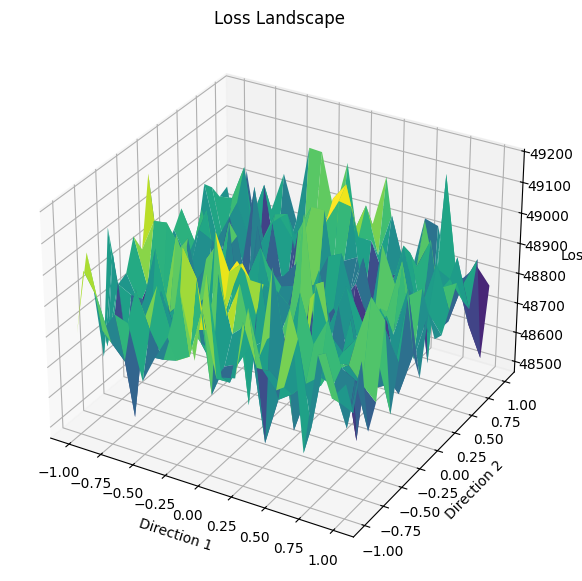

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))  # early stopping

plot_loss_landscape(model, val_dataloader, device)

In [ ]:
# print("Starting training...")
# for epoch in range(config['epochs']):
#     model.train()
#     train_loss = 0
#     epoch_recon_loss = 0
#     epoch_kl_loss = 0

#     for batch_idx, (batch,) in enumerate(dataloader):
#         batch = batch.to(device)

#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(batch)
#         loss, recon_loss, kl_loss = model.loss_function(recon_batch, batch, mu, logvar)

#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()

#         train_loss += loss.item()
#         epoch_recon_loss += recon_loss.item()
#         epoch_kl_loss += kl_loss.item()

#     # Average loss for the epoch
#     avg_loss = train_loss / len(dataloader.dataset)
#     avg_recon_loss = epoch_recon_loss / len(dataloader.dataset)
#     avg_kl_loss = epoch_kl_loss / len(dataloader.dataset)

#     train_losses.append(avg_loss)
#     recon_losses.append(avg_recon_loss)
#     kl_losses.append(avg_kl_loss)

#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch_idx, (val_batch,) in enumerate(val_dataloader):
#             val_batch = val_batch.to(device)
#             recon_batch, mu, logvar = model(val_batch)
#             loss, _, _ = model.loss_function(recon_batch, val_batch, mu, logvar)
#             val_loss += loss.item()

#     avg_val_loss = val_loss / len(val_dataloader.dataset)
#     vali_loss.append(avg_val_loss)
#     scheduler.step(avg_val_loss)

#     if (epoch + 1) % log_interval == 0:
#         print(f"Epoch: {epoch+1}/{config['epochs']} | Train Loss: {avg_loss:.4f} | "
#               f"Recon Loss: {avg_recon_loss:.4f} | KL Loss: {avg_kl_loss:.4f} | "
#               f"Val Loss: {avg_val_loss:.4f}")

Starting training...
Epoch: 10/200 | Train Loss: nan | Recon Loss: nan | KL Loss: nan | Val Loss: nan


KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

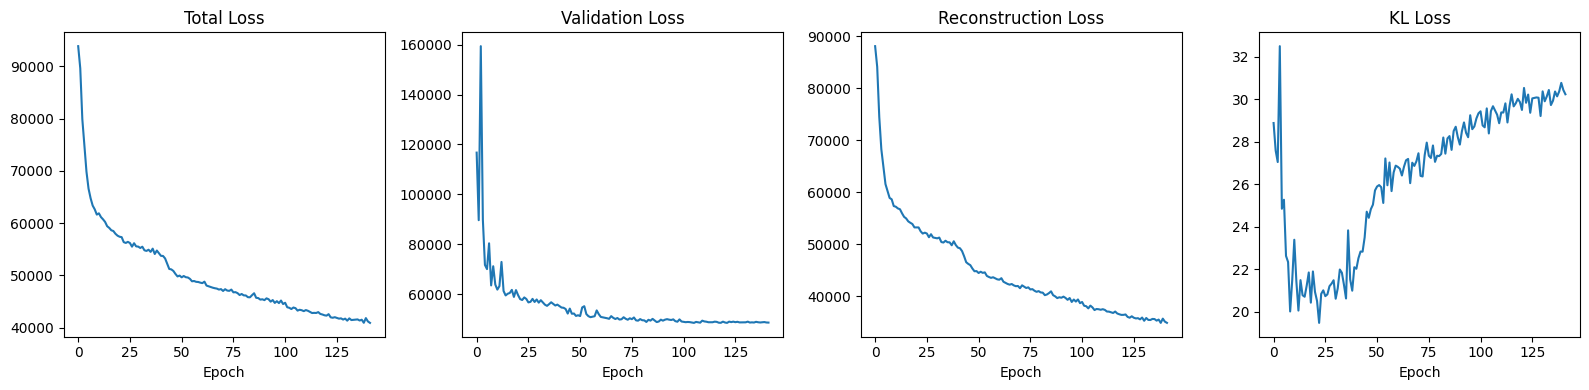

In [ ]:
# Plot loss curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(train_losses)
plt.title('Total Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 2)
plt.plot(vali_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 3)
plt.plot(recon_losses)
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 4)
plt.plot(kl_losses)
plt.title('KL Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()
# plt.savefig('vae_training_losses.png')
# plt.close()

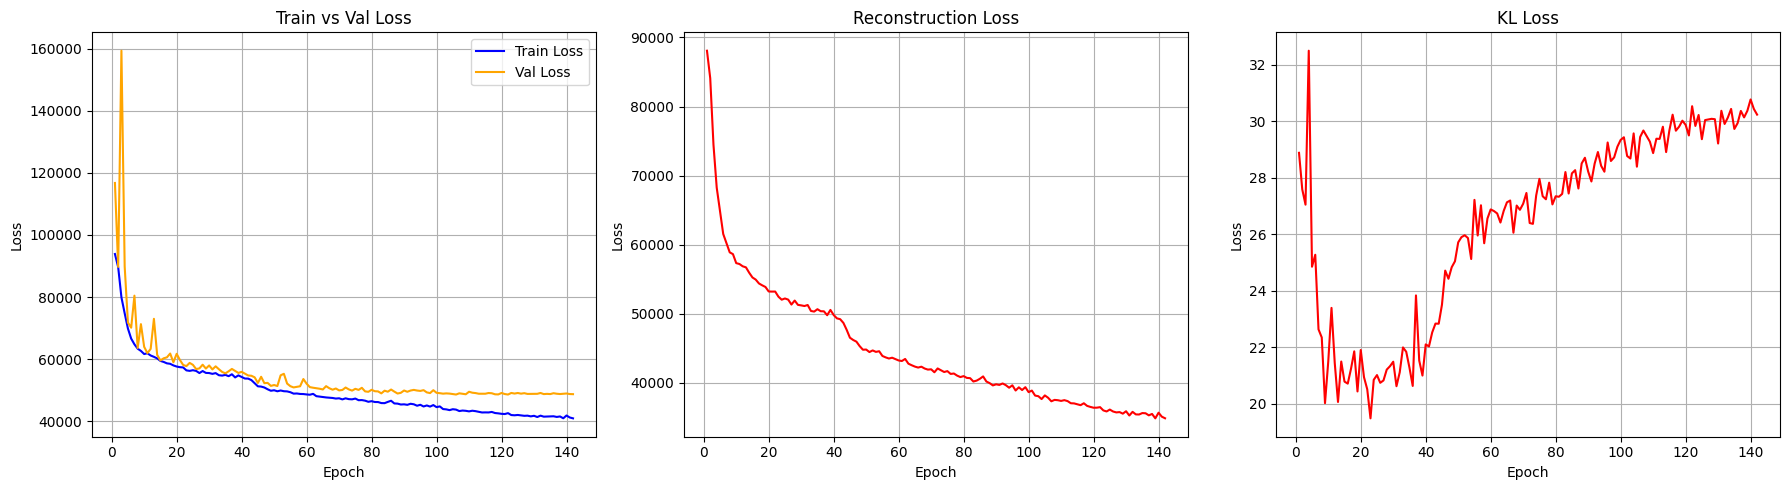

In [ ]:
c_epochs = list(range(1, len(train_losses) + 1))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Train vs Val Loss
axs[0].plot(c_epochs, train_losses, label='Train Loss', color='blue')
axs[0].plot(c_epochs, vali_loss, label='Val Loss', color='orange')
axs[0].set_title('Train vs Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Reconstruction Loss
axs[1].plot(c_epochs, recon_losses, label='Recon Loss', color='red')
axs[1].set_title('Reconstruction Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

# Subplot 3: KL Loss
axs[2].plot(c_epochs, kl_losses, label='KL Loss', color='red')
axs[2].set_title('KL Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Extract features from the latent space
def extract_latent_features(model, dataloader, device):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(dataloader):
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())

    return np.vstack(latent_vectors)

In [ ]:
# Create a new dataloader without shuffling to maintain order
eval_dataset = TensorDataset(data)
eval_dataloader = DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False)

# Extract latent features
print("Extracting latent features...")
latent_features = extract_latent_features(model, eval_dataloader, device)
print(f"Latent features shape: {latent_features.shape}")

Extracting latent features...
Latent features shape: (1115, 256)


In [ ]:
# File Save
np.save('/content/latent_features.npy', latent_features)

# Download
from google.colab import files
files.download('/content/latent_features.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Dimensionality reduction using PCA for initial analysis
print("Performing PCA...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_features)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

Performing PCA...
PCA explained variance ratio: [0.06453086 0.06011671]


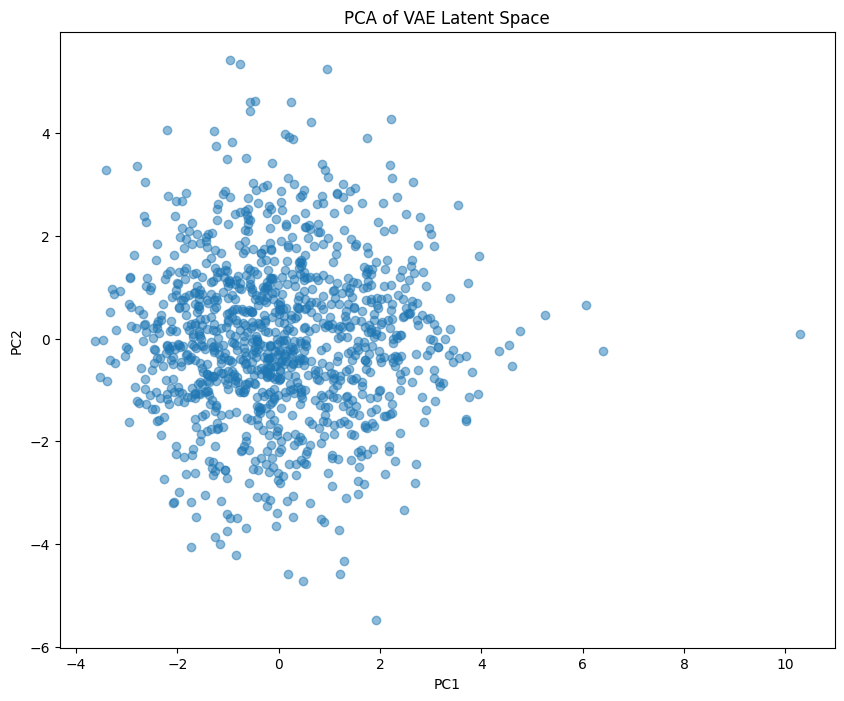

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of VAE Latent Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
# plt.savefig('pca_latent_space.png')
# plt.close()

In [ ]:
# Dimensionality reduction using UMAP
print("Performing UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = reducer.fit_transform(latent_features)

Performing UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


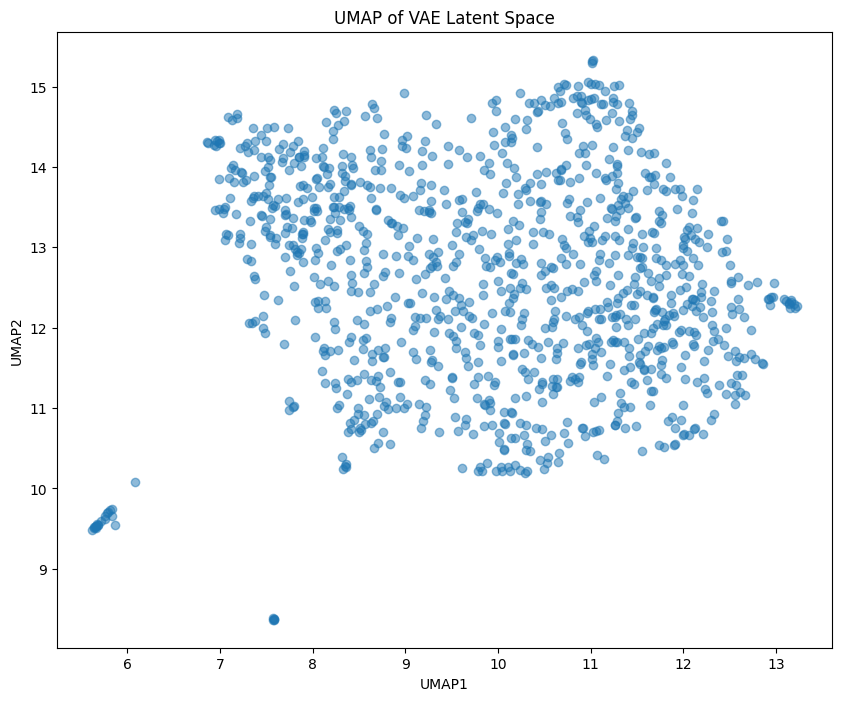

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.5)
plt.title('UMAP of VAE Latent Space')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()
# plt.savefig('umap_latent_space.png')
# plt.close()

In [ ]:
# K-Means clustering
print("Performing K-Means clustering...")
# Find optimal K using the elbow method
inertia = []
max_k = 20
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_features)
    inertia.append(kmeans.inertia_)

Performing K-Means clustering...


In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_features)

In [ ]:
# HDBSCAN clustering
print("Performing HDBSCAN clustering...")
hdb = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, cluster_selection_epsilon=0.5)
hdbscan_labels = hdb.fit_predict(latent_features)

Performing HDBSCAN clustering...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


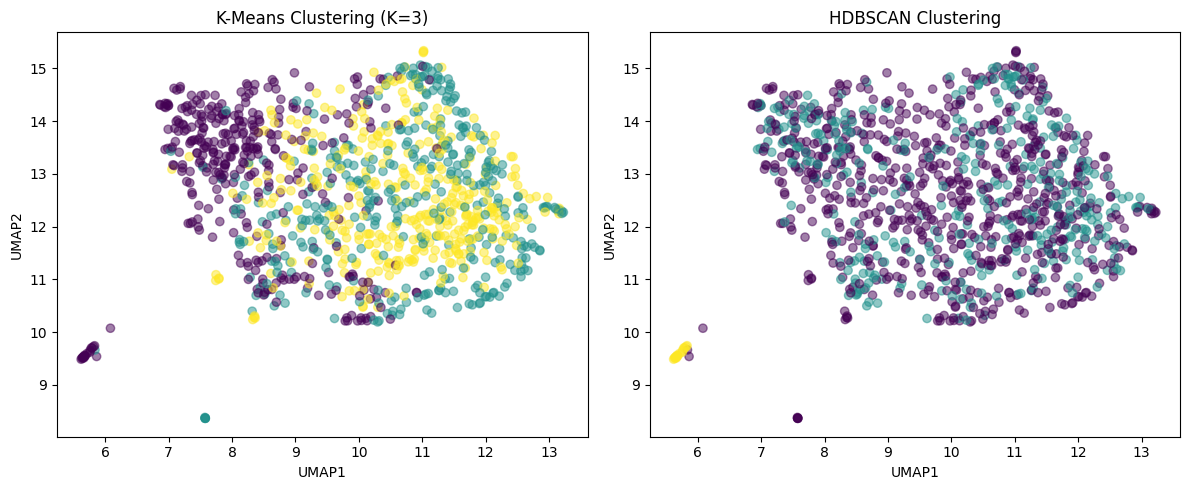

In [ ]:
# Visualize clustering results with UMAP
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.subplot(1, 2, 2)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdbscan_labels, cmap='viridis', alpha=0.5)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()
# plt.savefig('clustering_results_umap.png')
# plt.close()


Performing t-SNE...


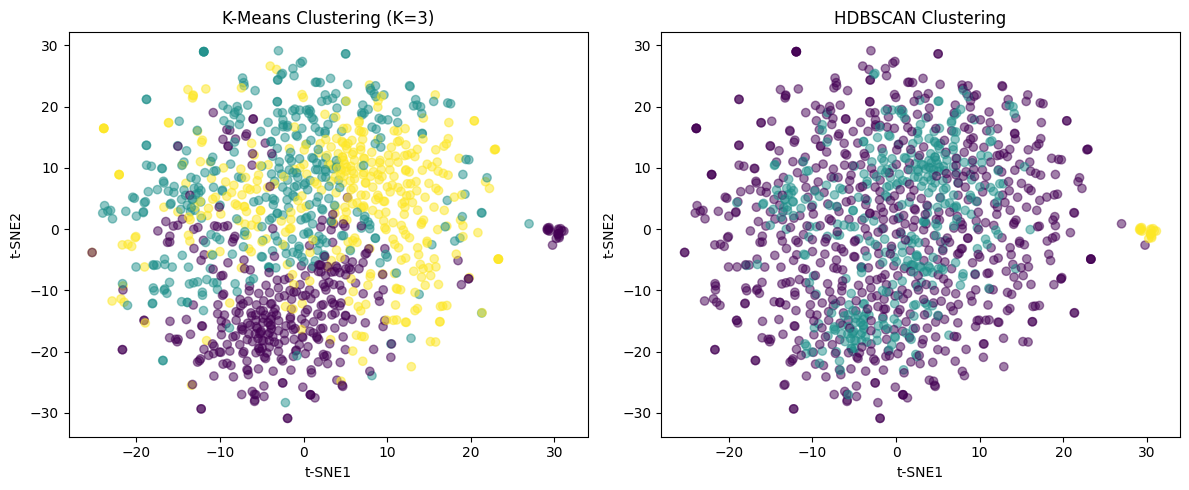

In [ ]:
# Visualize clustering results with t-SNE for comparison
print("Performing t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(latent_features)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=hdbscan_labels, cmap='viridis', alpha=0.5)
plt.title('HDBSCAN Clustering')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.tight_layout()
plt.show()
# plt.savefig('clustering_results_tsne.png')
# plt.close()

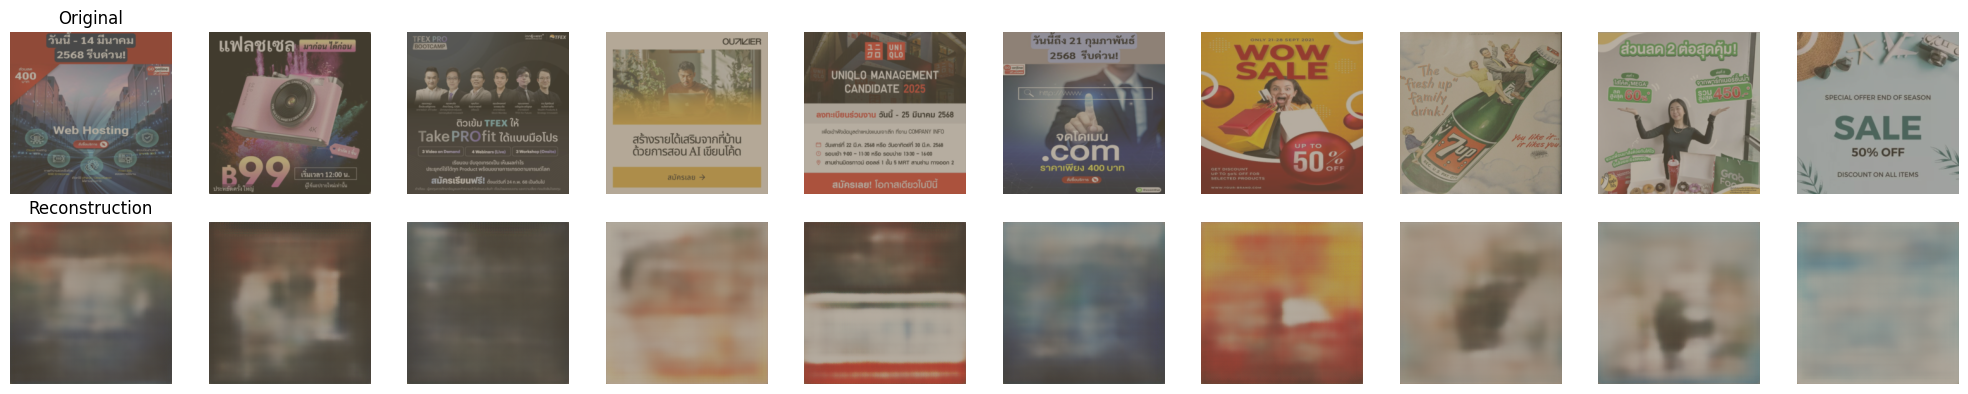

In [ ]:
# Function to visualize some reconstructed images
def visualize_reconstructions(model, dataloader, device, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(dataloader):
            batch = batch.to(device)
            recon_batch, _, _ = model(batch)

            # Denormalize images
            mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

            batch = batch * std + mean
            recon_batch = recon_batch * std + mean

            # Clamp values to be in [0, 1]
            batch = torch.clamp(batch, 0, 1)
            recon_batch = torch.clamp(recon_batch, 0, 1)

            # Plot some reconstructions
            plt.figure(figsize=(20, 4))
            for i in range(num_images):
                # Original
                plt.subplot(2, num_images, i + 1)
                plt.imshow(batch[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i == 0:
                    plt.title("Original")

                # Reconstruction
                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(recon_batch[i].cpu().permute(1, 2, 0))
                plt.axis('off')
                if i == 0:
                    plt.title("Reconstruction")

            plt.tight_layout()
            plt.show()
            # plt.savefig('reconstructions.png')
            # plt.close()
            break  # Just one batch

# Visualize some reconstructions
visualize_reconstructions(model, eval_dataloader, device)


In [ ]:
# Create a summary of clustering results
cluster_summary = {
    'kmeans': {
        'num_clusters': optimal_k,
        'cluster_sizes': [np.sum(kmeans_labels == i) for i in range(optimal_k)]
    },
    'hdbscan': {
        'num_clusters': len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0),
        'cluster_sizes': [np.sum(hdbscan_labels == i) for i in set(hdbscan_labels) if i != -1],
        'noise_points': np.sum(hdbscan_labels == -1) if -1 in hdbscan_labels else 0
    }
}

print("\nClustering Summary:")
print(f"K-Means: {cluster_summary['kmeans']['num_clusters']} clusters")
print(f"Cluster sizes: {cluster_summary['kmeans']['cluster_sizes']}")
print(f"\nHDBSCAN: {cluster_summary['hdbscan']['num_clusters']} clusters")
print(f"Cluster sizes: {cluster_summary['hdbscan']['cluster_sizes']}")
print(f"Noise points: {cluster_summary['hdbscan']['noise_points']}")


Clustering Summary:
K-Means: 3 clusters
Cluster sizes: [np.int64(353), np.int64(375), np.int64(387)]

HDBSCAN: 2 clusters
Cluster sizes: [np.int64(381), np.int64(17)]
Noise points: 717


In [ ]:
from sklearn.metrics import silhouette_score

ll = kmeans.labels_

silhouette_score(latent_features, ll)

np.float32(0.037183072)

In [ ]:
hdbscan_labels

array([-1, -1,  0, ..., -1, -1,  0])

In [ ]:
silhouette_score(latent_features, hdbscan_labels)

np.float32(-0.04422798)

In [ ]:
from sklearn.mixture import GaussianMixture


In [ ]:
print("Applying GMM clustering...")
gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)
gmm_labels = gmm.fit_predict(umap_result)

Applying GMM clustering...


In [ ]:
gmm_silhouette = silhouette_score(umap_result, gmm_labels)
gmm_silhouette

np.float32(0.3653613)

In [ ]:
kmeans.fit(umap_result)

KMeans(n_clusters=3, random_state=42)

In [ ]:
lf = kmeans.labels_

silhouette_score(umap_result, lf)

np.float32(0.3748918)

In [ ]:
hf = hdb.fit_predict(umap_result)

silhouette_score(umap_result, hf)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


np.float32(0.50596786)

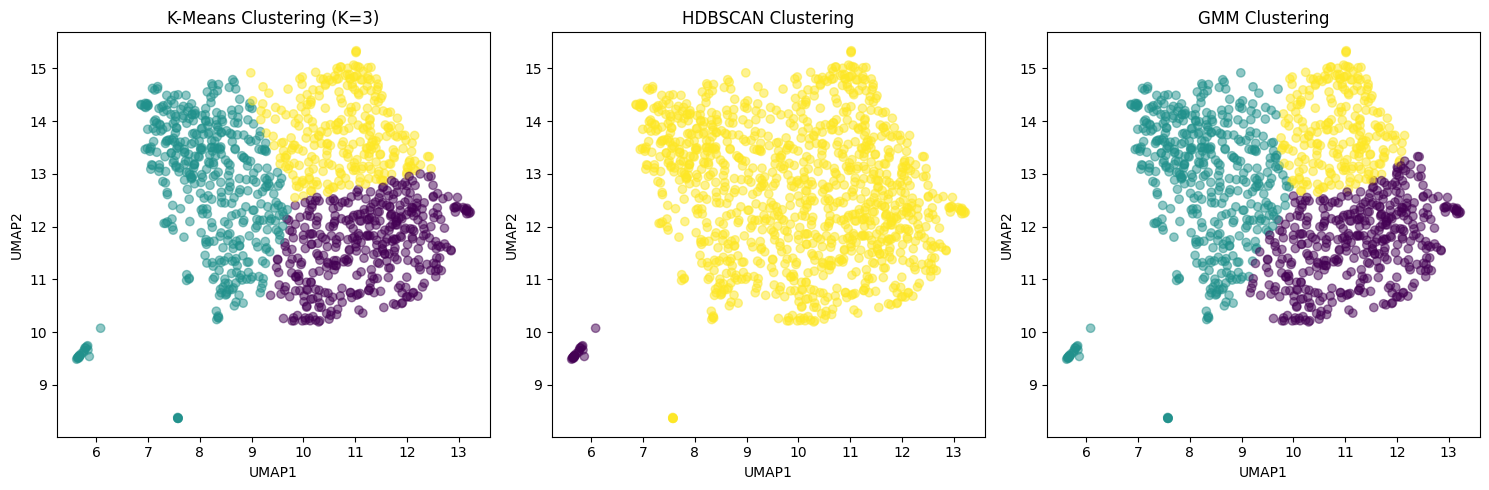

In [ ]:
# Visualize clustering results with UMAP
plt.figure(figsize=(15, 5))

# Subplot 1: K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=lf, cmap='viridis', alpha=0.5)
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Subplot 2: HDBSCAN Clustering
plt.subplot(1, 3, 2)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hf, cmap='viridis', alpha=0.5)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Subplot 3: GMM Clustering
plt.subplot(1, 3, 3)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.5)
plt.title('GMM Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
kmeans.fit(tsne_result)

k2 = kmeans_labels
silhouette_score(tsne_result, k2)

np.float32(0.09197693)

In [ ]:
h2 = hdb.fit_predict(tsne_result)
silhouette_score(tsne_result, h2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


np.float32(0.17201927)

In [ ]:
g2 = gmm.fit_predict(tsne_result)
silhouette_score(tsne_result, g2)

np.float32(0.37606356)

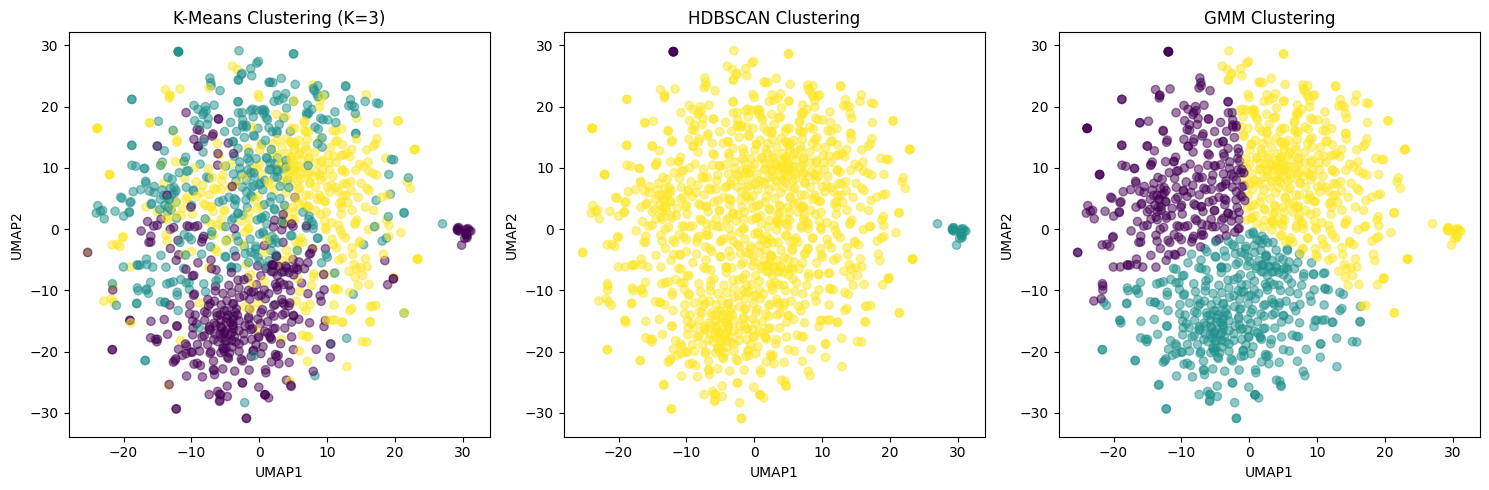

In [ ]:
# Visualize clustering results with TSNE
plt.figure(figsize=(15, 5))

# Subplot 1: K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=k2, cmap='viridis', alpha=0.5)
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Subplot 2: HDBSCAN Clustering
plt.subplot(1, 3, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=h2, cmap='viridis', alpha=0.5)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Subplot 3: GMM Clustering
plt.subplot(1, 3, 3)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=g2, cmap='viridis', alpha=0.5)
plt.title('GMM Clustering')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()